In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from config import PGHOST, PGDATABASE, PGUSER, PGPASSWORD

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
# Define a function to connect to AWS database instance

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
conn, cursor = connect()

Connected!


In [4]:
# Get the data, read SQL query into data frame
nf_data = pd.read_sql_query("SELECT * FROM netflix", con=conn)
nf_df = pd.DataFrame(nf_data)
nf_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [5]:
nf_df = nf_df.drop(['adj_close','volume'], axis=1)

nf_df.head()

,Date,open_price,high_price,low_price,close_price
0,2002-05-23,1.156429,1.242857,1.145714,1.196429
1,2002-05-24,1.214286,1.225000,1.197143,1.210000
2,2002-05-28,1.213571,1.232143,1.157143,1.157143
3,2002-05-29,1.164286,1.164286,1.085714,1.103571
4,2002-05-30,1.107857,1.107857,1.071429,1.071429


In [6]:
# Create a date series for plotting purpose
date_train = pd.to_datetime(nf_df['Date'])

date_train.head()

0   2002-05-23
1   2002-05-24
2   2002-05-28
3   2002-05-29
4   2002-05-30
Name: Date, dtype: datetime64[ns]

In [7]:
# Select "open, high, low, close" as input features

columns = list(nf_df)[1:5]

print(columns)

['open_price', 'high_price', 'low_price', 'close_price']


In [8]:
# Create a new dataframe with only training data - 4 columns

nf_training_df = nf_df[columns].astype(float)

nf_training_df.head()

,open_price,high_price,low_price,close_price
0,1.156429,1.242857,1.145714,1.196429
1,1.214286,1.225000,1.197143,1.210000
2,1.213571,1.232143,1.157143,1.157143
3,1.164286,1.164286,1.085714,1.103571
4,1.107857,1.107857,1.071429,1.071429


In [9]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaled the traing dataset

scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()
scaler = scaler.fit(nf_training_df)
scaled_training_data = scaler.transform(nf_training_df)

print(scaled_training_data.shape)

(5117, 4)


In [10]:
# LSTM require to reshape the input data into (n_samples, timesteps, n_features). 
# This project we choose n_features=4 and timesteps = 30 (past days data used for training). 
# Create empty X_train and y_train list 
X_train = []
y_train = []

training_data_len = round(len(scaled_training_data)*0.8)
# Define future days we want to predict and look-back days used for prediction

look_back = 30 # number of days to be used for prediction
num_future_days = 1 # number of days to be prediced

for i in range(look_back, training_data_len-num_future_days+1):
    X_train.append(scaled_training_data[i-look_back:i, 0:scaled_training_data.shape[1]])
    y_train.append(scaled_training_data[i+num_future_days-1:i+num_future_days, 3])

# Create X_test list

X_test = []

for j in range(training_data_len, len(scaled_training_data)-num_future_days+1):
    X_test.append(scaled_training_data[j-look_back:j, 0:scaled_training_data.shape[1]])

In [11]:
X_train, y_train, X_test = np.array(X_train), np.array(y_train), np.array(X_test)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4064, 30, 4)
(4064, 1)
(1023, 30, 4)


In [13]:
# Build the LSTM model

model = Sequential()

# Add two hidden layers
# model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=False))

model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=32, return_sequences=False))
# Add output layer, which contains 1 output
model.add(Dense(units=1))

# Complile the model 
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fit the model

model.fit(X_train, y_train, batch_size =32, epochs=20, verbose=1)

Epoch 1/20
127/127 [==============================] - 5s 14ms/step - loss: 4.6504e-04
Epoch 2/20
127/127 [==============================] - 2s 14ms/step - loss: 6.0923e-05
Epoch 3/20
127/127 [==============================] - 2s 14ms/step - loss: 9.1305e-05
Epoch 4/20
127/127 [==============================] - 2s 13ms/step - loss: 5.3794e-05
Epoch 5/20
127/127 [==============================] - 2s 13ms/step - loss: 4.7335e-05
Epoch 6/20
127/127 [==============================] - 2s 13ms/step - loss: 4.3208e-05
Epoch 7/20
127/127 [==============================] - 2s 13ms/step - loss: 4.3336e-05
Epoch 8/20
127/127 [==============================] - 2s 13ms/step - loss: 4.4509e-05
Epoch 9/20
127/127 [==============================] - 2s 13ms/step - loss: 4.0071e-05
Epoch 10/20
127/127 [==============================] - 2s 17ms/step - loss: 3.8831e-05
Epoch 11/20
127/127 [==============================] - 2s 13ms/step - loss: 4.2858e-05
Epoch 12/20
127/127 [==============================]

In [15]:
# Test the model
# Make prediction

prediction = model.predict(X_test)

print(prediction.shape)

32/32 [==============================] - 1s 6ms/step
(1023, 1)


In [16]:
#Perform inverse transformation to rescale back to original range
#Since we used 4 variables for transform, the inverse expects same dimensions
#Therefore, we copy our prediction values 4 times and discard them after inverse transform

prediction_copies = np.repeat(prediction, scaled_training_data.shape[1], axis=-1)
print(prediction_copies)

[[0.50210565 0.50210565 0.50210565 0.50210565]
 [0.51445764 0.51445764 0.51445764 0.51445764]
 [0.51967674 0.51967674 0.51967674 0.51967674]
 ...
 [0.32290134 0.32290134 0.32290134 0.32290134]
 [0.32633826 0.32633826 0.32633826 0.32633826]
 [0.33198532 0.33198532 0.33198532 0.33198532]]


In [17]:
# Discard the extra columns
y_pred = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred.shape)

(1023,)


In [18]:
# Create the y_test data to compare with the predictions

close_df = pd.DataFrame({'Date':nf_df['Date'], 'close_price':nf_training_df['close_price']})
y_test = close_df[training_data_len:]
y_test.head()

,Date,close_price
4094,2018-08-27,364.58
4095,2018-08-28,368.49
4096,2018-08-29,368.04
4097,2018-08-30,370.98
4098,2018-08-31,367.68


In [19]:
print(y_test['close_price'].shape)

(1023,)


In [20]:
# Calculate the MSE

print(mean_squared_error(y_test['close_price'], y_pred))

468.0913527523226


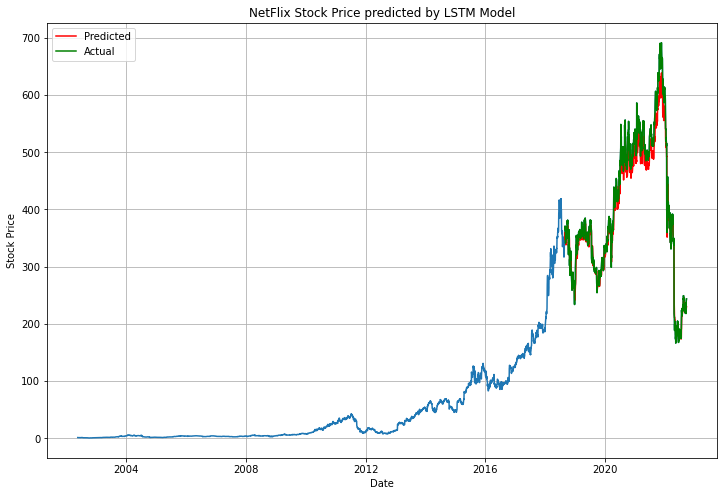

In [21]:
# plot test predictions

plt.figure(figsize=(12, 8))
plt.plot(date_train, nf_training_df['close_price'])
plt.plot(y_test['Date'], y_pred, color='red', label='Predicted')
plt.plot(y_test['Date'], y_test['close_price'], color='green', label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.title("NetFlix Stock Price predicted by LSTM Model")
plt.grid()
plt.legend()
plt.show()